In [8]:
import numpy as np 
import matplotlib.pyplot as plt
import os, json, glob, re
import pandas as pd
import seaborn as sns

sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

In [9]:
# Collect all mesh_properties.json in CT and E8 80um folders and assemble a rich DataFrame
ct_folder = "results/CT/rves/80um"
e8_folder = "results/E8/rves/80um"

rows = []

def parse_sample_coords(path: str):
    # Expect .../<Y>_<X>_<Z>/mesh_properties.json or similar folder name
    # We'll attempt to extract trailing 3 integers from the directory name
    base = os.path.basename(os.path.dirname(path))
    m = re.findall(r"-?\d+", base)
    if len(m) >= 3:
        try:
            return int(m[-3]), int(m[-2]), int(m[-1])
        except Exception:
            return None, None, None
    return None, None, None

for mode, root in [("CT", ct_folder), ("E8", e8_folder)]:
    json_files = glob.glob(os.path.join(root, "*", "mesh_properties.json"))
    print(f"Found {len(json_files)} json files in {root}")
    for jf in json_files:
        with open(jf, 'r') as f:
            data = json.load(f)
        # data is expected to be a dict, often keyed by an identifier. Flatten to rows.
        # If it's a single JSON object with fields, wrap it; if dict-of-dicts, iterate items.
        if isinstance(data, dict) and all(isinstance(v, dict) for v in data.values()):
            items = data.items()
        else:
            items = [(os.path.basename(os.path.dirname(jf)), data)]

        for key, props in items:
            row = {"mode": mode, "folder": os.path.dirname(jf), "id": key}
            y, x, z = parse_sample_coords(jf)
            if y is not None:
                row.update({"sample_y": y, "sample_x": x, "sample_z": z})
            # bring top-level features directly (porosity, areas, counts, etc.)
            if isinstance(props, dict):
                for k, v in props.items():
                    # Convert lists/arrays to scalars when appropriate, else keep JSON-serializable
                    if isinstance(v, (list, tuple)) and len(v) == 1:
                        row[k] = v[0]
                    else:
                        row[k] = v
            rows.append(row)

# Build DataFrame
if rows:
    df = pd.DataFrame(rows)
else:
    df = pd.DataFrame()

# Attempt to coerce numeric columns where possible
for col in df.columns:
    if col in ("mode", "folder", "id"): # keep as categorical/text
        continue
    df[col] = pd.to_numeric(df[col], errors='ignore')

print(f"DataFrame shape: {df.shape}")
print(df.head())

# Persist a CSV for external analysis
out_csv = "rves_80um_properties_all.csv"
df.to_csv(out_csv, index=False)
print(f"Saved {out_csv}")

Found 98 json files in results/CT/rves/80um
Found 0 json files in results/E8/rves/80um
DataFrame shape: (98, 12)
  mode                                  folder                 id  sample_y  \
0   CT     results/CT/rves/80um/2073_2231_1259     2073_2231_1259      2073   
1   CT     results/CT/rves/80um/2141_2142_1748     2141_2142_1748      2141   
2   CT  results/CT/rves/80um/bad_2150_2483_151  bad_2150_2483_151      2150   
3   CT     results/CT/rves/80um/2705_2070_1455     2705_2070_1455      2705   
4   CT      results/CT/rves/80um/881_1302_1820      881_1302_1820       881   

   sample_x  sample_z                                      final_surface  \
0      2231      1259  {'area': 14.24044559618589, 'connected_compone...   
1      2142      1748  {'area': 15.142212694456264, 'connected_compon...   
2      2483       151  {'area': 16.298800159539724, 'connected_compon...   
3      2070      1455  {'area': 16.848748484182426, 'connected_compon...   
4      1302      1820  {'area': 

/tmp/ipykernel_147085/1133813818.py:57: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [11]:
# list all fields in df

print("Columns in DataFrame:")
print(df.columns.tolist())

Columns in DataFrame:
['mode', 'folder', 'id', 'sample_y', 'sample_x', 'sample_z', 'final_surface', 'flags', 'flat_face_areas', 'periodic_pairs', 'tet_volume', 'tet_vs_stl_percent_diff']


In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)
df["porosity"] = 1 - df["tet_volume"] 
print(type(df["porosity"]))

Numeric columns: ['sample_y', 'sample_x', 'sample_z', 'tet_volume', 'tet_vs_stl_percent_diff']
<class 'pandas.core.series.Series'>


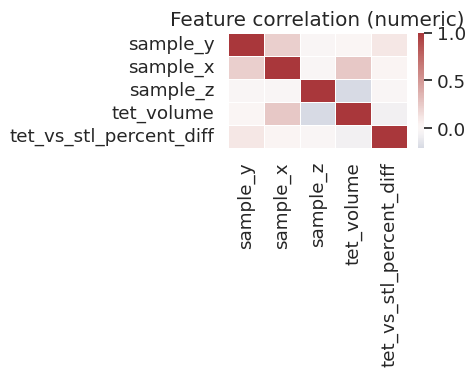

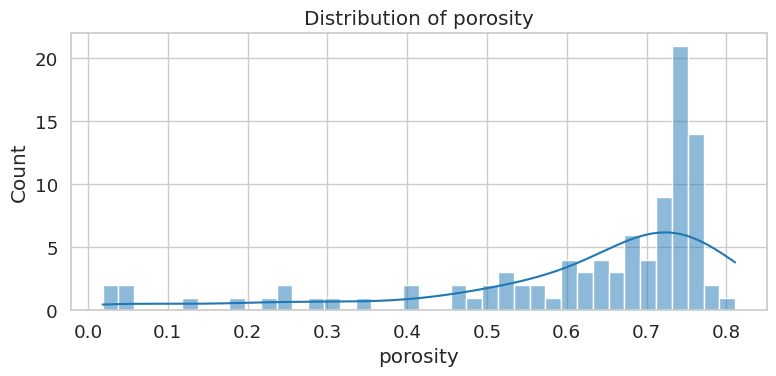

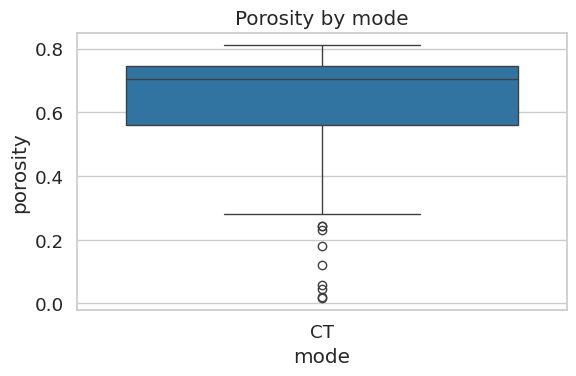

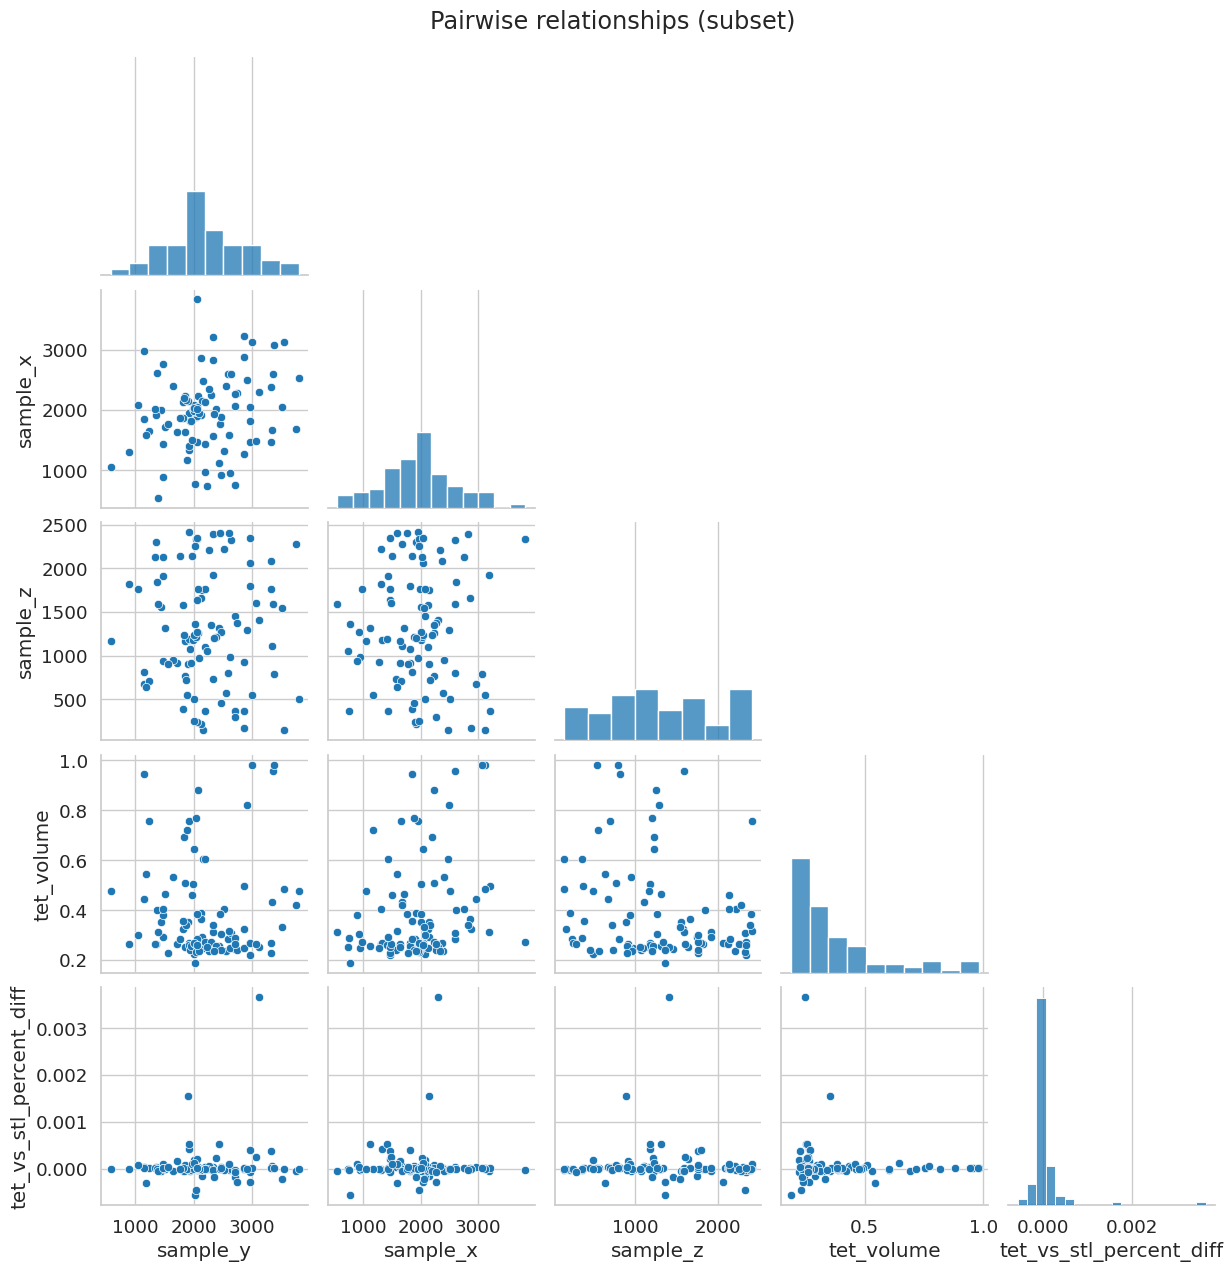

In [17]:
# Quick EDA: correlations and key distributions
if not df.empty:
    # numeric_cols = df.select_dtypes(include=["number"]).columns
    if len(numeric_cols) > 1:
        plt.figure(figsize=(5,4))
        corr = df[numeric_cols].corr(numeric_only=True)
        sns.heatmap(corr, cmap="vlag", center=0, annot=False, linewidths=0.5)
        plt.title("Feature correlation (numeric)")
        plt.tight_layout()
        plt.show()

    # Porosity distribution if present under typical keys
    plt.figure(figsize=(8,4))
    sns.histplot(df["porosity"].dropna(), bins=40, kde=True)
    plt.title(f"Distribution of porosity")
    plt.xlabel("porosity")
    plt.tight_layout()
    plt.show()

    # porosity boxplot
    plt.figure(figsize=(6,4))
    sns.boxplot(x="mode", y="porosity", data=df)
    plt.title("Porosity by mode")
    plt.tight_layout()
    plt.show()

    # Pairplot over a subset of numeric columns (limit to 6 to keep it light)
    subset = numeric_cols[:6]
    if len(subset) >= 2:
        g = sns.pairplot(df[subset], corner=True, diag_kind="hist")
        g.fig.suptitle("Pairwise relationships (subset)", y=1.02)
        plt.show()

else:
    print("No data loaded; check the folders and JSON structure.")